# Simpeg 2D inversion Using MTpy-v2 tools

This is an example of how to use MTpy-v2 tools to integrate with Simpeg to build an inversion.  

The recipe in MTpy-v2 is to create a quadree mesh from the given data, then invert the data using computed data errors




In [1]:
import numpy as np

from mtpy import MTCollection
from mtpy.modeling.simpeg.recipes import Simpeg2D

## Data

We are going to load in data from a synthetic model data. Some notes on the data

 - The data were modeled to be in Australia which is why the EPSG is 4462 (the UTM datum for all of Australia).  
 - The data are already in a profile, but we will demonstrate how to extract a profile line from the data by using the end points (usually in lat, lon).  
 - The data are modeled from 3E-4 to 1E+3.
 - There are 7 data sets with survey name
   - 'conductive_cube'          --> conductive cube in the upper crust
   - 'faults'                   --> a couple of faults that trend in various directions
   - 'layered_halfspace'        --> a 3 layered half space  
   - 'ne_conductor'             --> a Northeast trending conductive cube in the upper crust
   - 'ne_faults'                --> a couple of northeast trending faults
   - 'near_surface_conductor'   --> a shallow conductor
   - 'resistive_cube'           --> same as conductive cube, just resistive

## Modelling Workflow

 1) Read in EDI files into an MTData object
 2) Project station locations onto a UTM grid (EPSG = 4462)
 3) Extract the profile
 4) Interpolate onto a common period map
 5) Compute data errors for modeling (usually set an error floor)
 6) Make a mesh
 7) Set up inversion
 8) Run inversion
 9) Look at results

### 1) load in data to an MTData object

We are loading in the data from a premade MTH5 file that has multiple different surveys in it.  Here you can set the `survey_name` to one of the options above.

In [2]:
survey_name = "layered_halfspace"

In [3]:

with MTCollection() as mc:
    mc.open_collection(r"../../data/transfer_functions/forward_profiles.h5")
    mc.working_dataframe = mc.master_dataframe[mc.master_dataframe.survey == survey_name]
    md = mc.to_mt_data()


24:10:23T15:09:56 | INFO | line:777 |mth5.mth5 | close_mth5 | Flushing and closing ..\..\data\transfer_functions\forward_profiles.h5


### Data Periods

Lets see what is the period range of the data, so we can make some educated decisions about what periods to invert, how many, etc.

In [4]:
md.get_periods()

array([3.16227732e-04, 1.00000010e-03, 3.16227732e-03, 1.00000000e-02,
       3.16227732e-02, 1.00000000e-01, 3.16227732e-01, 1.00000000e+00,
       3.16227732e+00, 1.00000000e+01, 3.16227732e+01, 1.00000000e+02,
       3.16227732e+02, 1.00000000e+03])

### 2) Set UTM Grid

In [5]:

md.utm_epsg = 4426

#### 2a) plot stations

24:10:23T15:10:01 | WARNING | line:163 |mtpy.imaging.plot_stations | plot | Could not add base map because HTTPSConnectionPool(host='basemap.nationalmap.gov', port=443): Max retries exceeded with url: /arcgis/rest/services/USGSTopo/MapServer/tile/12/2408/3636 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1129)')))


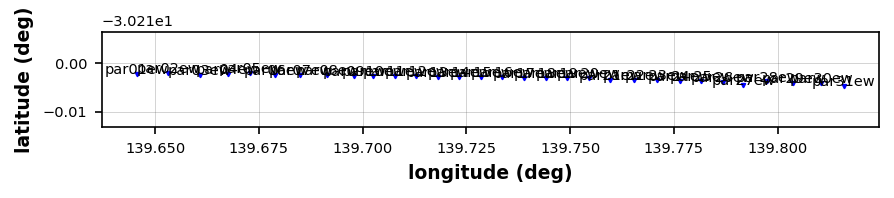

In [6]:

station_plot = md.plot_stations()

### 3) Extract profile

This is an example of how to extract a profile from a grid of stations.  You need to know the end points of the profile, usually in (longitude, latitude) and then you can set a distance from that profile line to include station.  

<div class="alert alert-block alert-info">
<b>Note:</b> You should pick your profile line to be approximately perpendicular to geoelectric strike.  To look at geoelectric strike you can use MTData.plot_strike().  See also MTData.generate_profile_from_strike()
</div>

In [7]:

profile = md.get_profile(139.50, -30.211997, 139.9, -30.214724527777776, 5000)

#### 3a) plot profile

Be sure you got all the station you were asking for and plot some responses and a pseudo section of apparent resistivity and phase to make sure the data is what you expect.

24:10:23T15:10:03 | WARNING | line:163 |mtpy.imaging.plot_stations | plot | Could not add base map because HTTPSConnectionPool(host='basemap.nationalmap.gov', port=443): Max retries exceeded with url: /arcgis/rest/services/USGSTopo/MapServer/tile/12/2408/3636 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1129)')))


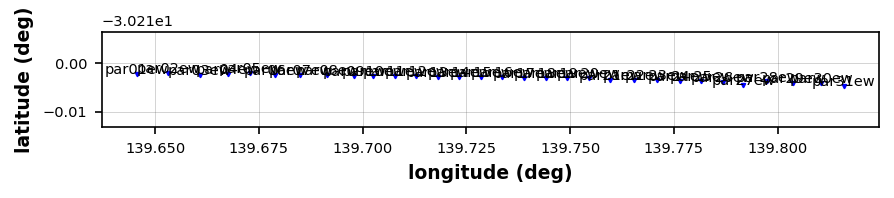

In [8]:

plot_profile = profile.plot_stations()

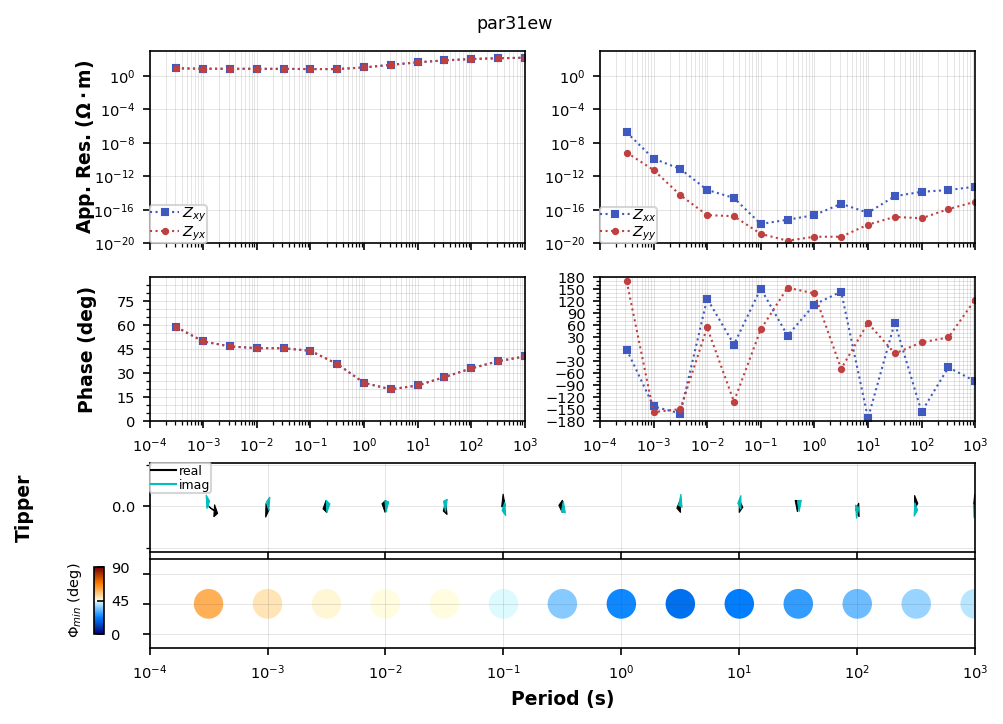

Plotting PlotMTResponse

In [9]:
profile[f'{survey_name}.par31ew'].plot_mt_response(plot_num=2)

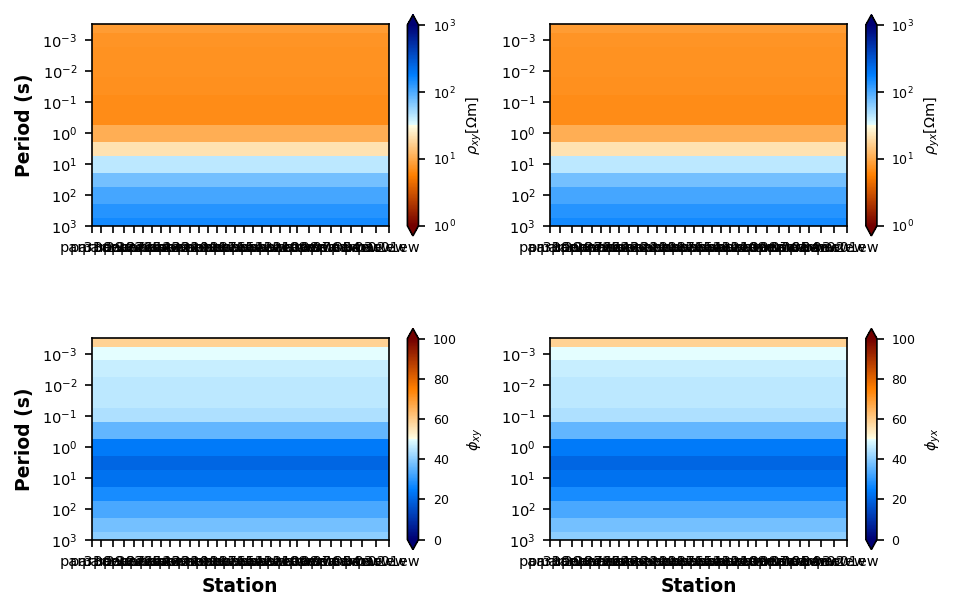

Plotting PlotResPhasePseudoSection

In [10]:
profile.plot_resistivity_phase_pseudosections(y_stretch=10000)

### 4) Interpolate data onto the same period map
It is important to use bounds_error=False, which will put Nan where data cannot be interpolated. Interpolate onto a period range that keeps the mesh small. 

The first number is the highest frequency, shortest period. The data were modelled up to period of 1E-4.  If we use high frequencies it will add more cells to the model because of the skin depth principle. 

The second number is the lowest frequency, longest period.  The data were modelled to 1E3.  These help get deep structure and also lateral structure.

The third number is the number of periods to use.  A higher number can provide more resolution, but will take longer to invert.  

Play around with these numbers to see how they affect the inversion results.

In [11]:

profile.interpolate(np.logspace(-2, 2, 5), inplace=True, bounds_error=False)

### 5) Set data modeling errors

Here we are setting an error floor of 5 % for the impedance, which is about 10% for apparent resistivity and 2.5 degrees in phase. 

A higher error floor will allow the inversion more freedom to fit the data, and usually results in smooth models.  A lower error floor will force the inversion to fit the data more accurately, usually resulting in sharper models.

In [12]:

profile.z_model_error.error_value = 5
profile.z_model_error.error_type = "percent"
profile.z_model_error

Model Errors:
--------------------
	error_type:    percent
	error_value:   0.05
	floor:         True
	mode:          impedance

In [13]:
profile.compute_model_errors()

### Check Input Data

We want to make sure we haven't done anything crazy and the input data looks the way we expect.  We will plot pseudo sections of the apparent resistivity and phase, which is a good proxy for what the expected model should look like.

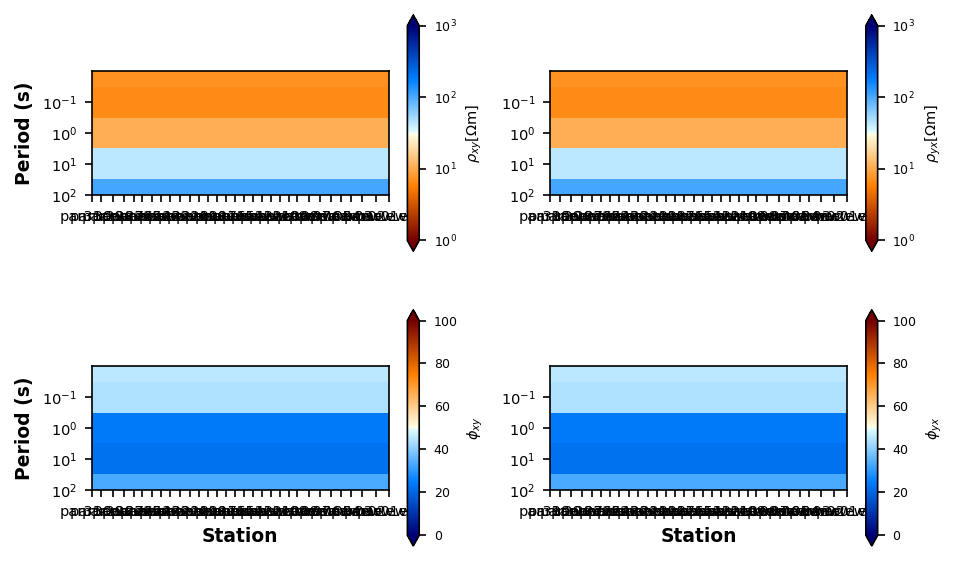

Plotting PlotResPhasePseudoSection

In [14]:
profile.plot_resistivity_phase_pseudosections(y_stretch=10000)

### Estimate Starting Half-Space

Here we can estimate a starting resistivity value for the model.

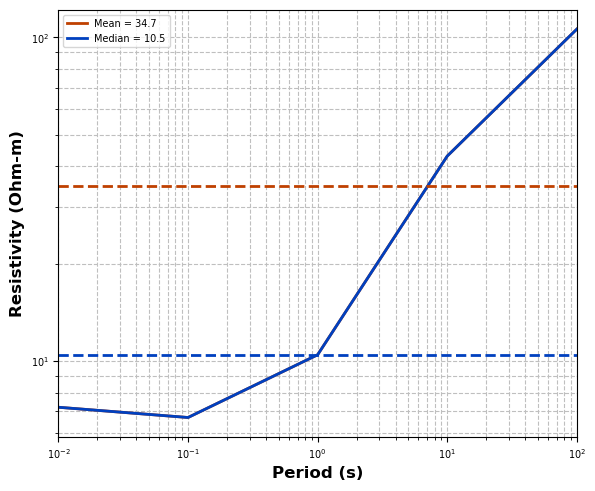

In [15]:
profile.estimate_starting_rho()

### 6-8) Create Mesh and setup Inversion

Now use a somewhat standard recipe to invert the data.  User has lots of control of parameters for mesh building, inversion norms, smallness, etc.  This recipe is meant as a convenience object.  For advanced users and those who want to fully understand the Simpeg workflow should build their own recipe.

Here the input data is a Pandas Dataframe. Note that if you want to invert the impedance elements instead of apparent resistivity and phase set the `data_kwargs={"invert_impedance": True}`, otherwise the default is to invert apparent resistivity and phase.  

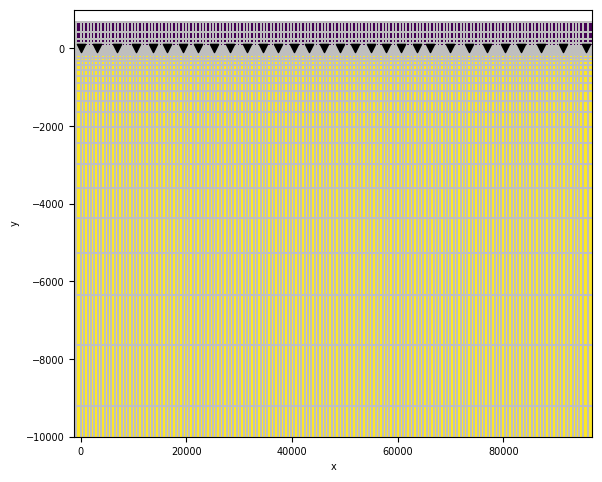

In [16]:
simpeg_2d = Simpeg2D(
    profile.to_dataframe(impedance_units="ohm"),
    mesh_kwargs={"sigma_background": 1./100},
    data_kwargs={"invert_impedance":True},
    max_iterations=10,
    alpha_s = 1e-15,
    alpha_y = 1.,
    alpha_z = 0.5, 
    )
simpeg_2d.data.dataframe['phase_yx_model_error'] = 5.
simpeg_2d.data.dataframe['phase_xy_model_error'] = 5.
#simpeg_2d.data.dataframe['res_yx_model_error'] = 10.
#simpeg_2d.data.dataframe['res_xy_model_error'] = 10.

In [17]:
print(simpeg_2d.mesh.mesh)


  TensorMesh: 8,736 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    168   -109,136.87    204,152.87    642.00 37,020.96    1.50
   y     52   -895,127.73        672.56     34.00 149,216.29    1.50




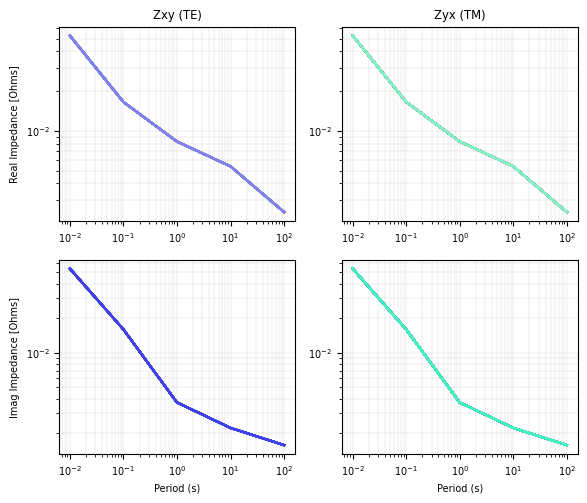

In [18]:
simpeg_2d.data.plot_response()

In [19]:
%%time
inversion_output = simpeg_2d.run_inversion()


Running inversion with SimPEG v0.22.1

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DMagneticField problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.16e-01  5.27e+05  0.00e+00  5.27e+05    3.03e+04      0              
   1  3.08e-01  6.56e+04  5.44e-04  6.56e+04    5.28e+03      0              
   2  1.54e-01  2.92e+03  9.44e+01  2.93e+03    5.26e+02      0   Skip BFGS  
   3  7.71e-02  4.02e+02  1.78e+02  4.16e+02    9.93e+01      0   Skip BFGS  
   4  3.85e-02  1.17e+02  2.00e+02  1.24e+02    4.89e+01      0              
   5  1.93e-02  8.09e+01  2.18e+02  8.52e+01    3.69e+01      0   

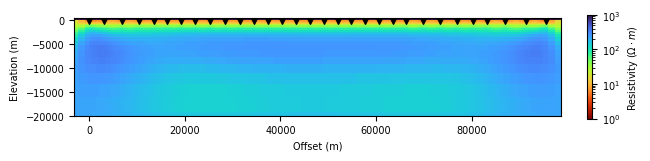

In [20]:
simpeg_2d.plot_iteration(10, z_limits=(-20000, 500), vmin=1, vmax=1000)

### Plot Tikhanov Curve

Here we can see how the inversion got to an answer.  Iterations go from left to right.

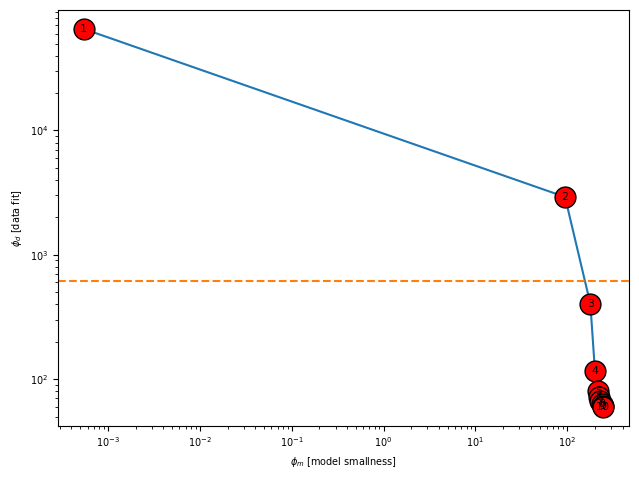

In [21]:
simpeg_2d.plot_tikhonov_curve()

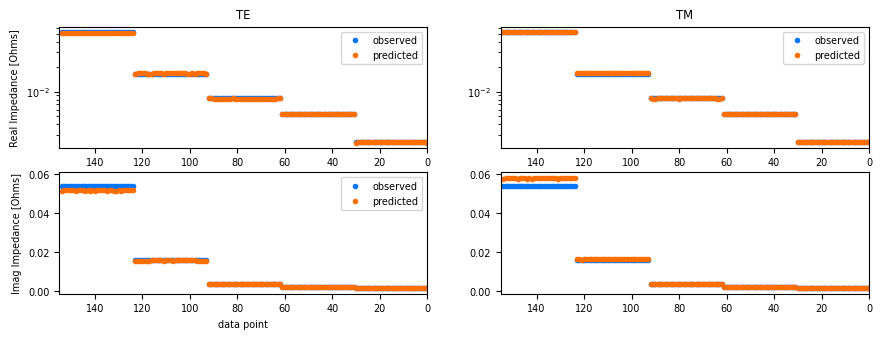

In [22]:
simpeg_2d.plot_responses(10)